In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.ae_v5 import Autoencoder as ae_v5
from tools.ae_v6 import Autoencoder as ae_v6
from tools.ae_v7 import Autoencoder as ae_v7
from tools.ae_v8 import Autoencoder as ae_v8
from tools.ae_v11 import Autoencoder as ae_v11
from tools.ae_v12 import Autoencoder as ae_v12

In [8]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-17 12:48:34.660806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 12:48:34.661080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 12:48:34.695846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 12:48:34.696115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-17 12:48:34.696322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [9]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [10]:
prng_seed = 42
np.random.seed(prng_seed)

train_split = 0.8
val_split = 0.1
test_split = 0.1

In [11]:
from numpy import *

data_dir_idx = '000'

dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
Re = params_dict['Re']
delta_t = params_dict['dTr']

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

24 <class 'int'>


In [12]:
all_data_og = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data_og[:, 0, :, :] = u_ref
del(u_ref)
all_data_og[:, 1, :, :] = v_ref
del(v_ref)

In [13]:
num_params = 1
og_vars = all_data_og.shape[1:]
all_data_og_shape = all_data_og.shape

print('num_params : ', num_params)
print('og_vars : ', og_vars)
print('all_data_og.shape : ', all_data_og_shape)

num_params :  1
og_vars :  (2, 50, 50)
all_data_og.shape :  (100001, 2, 50, 50)


In [14]:
all_data_og = all_data_og[::3]
all_data_og_shape = all_data_og.shape
print('all_data_og.shape : ', all_data_og_shape)

all_data_og.shape :  (33334, 2, 50, 50)


In [15]:
num_train = int(all_data_og.shape[0]*train_split)
num_val = int(all_data_og.shape[0]*val_split)
num_test = all_data_og.shape[0] - num_train - num_val

idx = np.arange(all_data_og.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)

training_data[:] = all_data_og[idx[0:num_train]]
val_data[:] = all_data_og[idx[num_train:num_train+num_val]]
testing_data[:] = all_data_og[idx[num_train+num_val:]]

In [16]:
del(all_data_og)

In [17]:
print('training_data.shape : ', training_data.shape)
print('val_data.shape : ', val_data.shape)
print('testing_data.shape : ', testing_data.shape)

training_data.shape :  (26667, 2, 50, 50)
val_data.shape :  (3333, 2, 50, 50)
testing_data.shape :  (3334, 2, 50, 50)


In [18]:
podcentering_means_trainingdata = np.mean(training_data[:], axis=0)
meancentered_trainingdata = training_data[:] - podcentering_means_trainingdata
meancentered_trainingdata_flat = np.reshape(meancentered_trainingdata, (meancentered_trainingdata.shape[0], -1))

covmat_trainingdata = np.matmul(
    meancentered_trainingdata_flat.transpose(),
    meancentered_trainingdata_flat
) / (meancentered_trainingdata_flat.shape[0] - 1)
# eigvals_og = np.abs(np.linalg.eigvals(covmat_og))
# eigvals_og = np.sort(eigvals_og)
# eigvals_og = eigvals_og[::-1]

eigenvals_trainingdata, eigenvecs_trainingdata = linalg.eig(covmat_trainingdata)
sorted_idx = np.argsort(eigenvals_trainingdata)
eigenvals_trainingdata = eigenvals_trainingdata[sorted_idx]
eigenvecs_trainingdata = eigenvecs_trainingdata[:, sorted_idx]

eigvals_og = np.abs(eigenvals_trainingdata)
eigvals_og = np.sort(eigvals_og)[::-1]

In [19]:
print('eigvals sum (trainingdata) : ', np.sum(eigvals_og))

eigvals sum (trainingdata) :  3061.7083


In [20]:
podcentering_means_testingdata = np.mean(testing_data[:], axis=0)
meancentered_testingdata = testing_data[:] - podcentering_means_testingdata
meancentered_testingdata_flat = np.reshape(meancentered_testingdata, (meancentered_testingdata.shape[0], -1))

covmat_testingdata = np.matmul(
    meancentered_testingdata_flat.transpose(),
    meancentered_testingdata_flat
) / (meancentered_testingdata_flat.shape[0] - 1)
# eigvals_og = np.abs(np.linalg.eigvals(covmat_og))
# eigvals_og = np.sort(eigvals_og)
# eigvals_og = eigvals_og[::-1]

eigenvals_testingdata, eigenvecs_testingdata = linalg.eig(covmat_testingdata)
sorted_idx = np.argsort(eigenvals_testingdata)
eigenvals_testingdata = eigenvals_testingdata[sorted_idx]
eigenvecs_testingdata = eigenvecs_testingdata[:, sorted_idx]

eigvals_og = np.abs(eigenvals_testingdata)
eigvals_og = np.sort(eigvals_og)[::-1]

In [21]:
print('eigvals sum (testingdata) : ', np.sum(eigvals_og))

eigvals sum (testingdata) :  3056.469


In [22]:
dir_name_all_ae = os.getcwd()+'{ds}saved_ae'.format(ds=dir_sep)
# dir_contents_list = os.listdir(dir_name_all_ae)
# chosen_dir_list = []
# for elem in dir_contents_list:
#     dir_name_ae = dir_name_all_ae + dir_sep + elem
#     if os.path.isdir(dir_name_ae):
#         with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
#             lines = f.readlines()
#             params_dict = eval(''.join(lines))
#             if data_dir_idx == params_dict['data_dir_idx']:
#                 chosen_dir_list.append(elem)

chosen_dir_list = [
    'ae_051',
    'ae_049',
    'ae_052',
    'ae_053',
]
print('chosen_dir_list:', chosen_dir_list)

chosen_dir_list: ['ae_051', 'ae_049', 'ae_052', 'ae_053']


In [23]:
latent_states_shape_list = []
latent_states_size_list = []
kernel_size_list = []
attention_used_list = []
timeAvgEnergySpectrum = []
covmat_list_AE = []
eigvals_list_AE = []
latent_states_covmat_list = []
latent_states_eigenvals_list = []

AE_recon_MSE_lst = []
AE_recon_RMSE_lst = []
AE_recon_NMSE_lst = []
AE_recon_NRMSE_lst = []
AE_recon_newNRMSE_lst = []
AE_recon_newNMSE_lst = []

for elem in chosen_dir_list:
    print('\n\n-------------------- {} --------------------'.format(elem))
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    ae_module = params_dict['module']
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
    
    # dealing with normalizing the data before feeding into autoencoder
    all_data = testing_data
    if normalizeforae_flag == True:
        all_data = testing_data.copy()
        all_data[:] -= normalization_constant_arr_aedata[0]
        all_data[:] /= normalization_constant_arr_aedata[1]
    # if ae_data_with_params == False:
    #     all_data = all_data[:, 0:og_vars]
    
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

    print('ae_module : ', ae_module)
    if ae_module.endswith('ae_v5') or ae_module.endswith('ae_v7'):
        Autoencoder = ae_v7
    elif ae_module.endswith('ae_v6') or ae_module.endswith('ae_v8'):
        Autoencoder = ae_v8
    elif ae_module.endswith('ae_v11'):
        Autoencoder = ae_v11
    elif ae_module.endswith('ae_v12'):
        Autoencoder = ae_v12

    ae_net = Autoencoder(load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)
    ae_net.load_weights(wt_file, by_name=True)
    
    attention_used_list.append(ae_net.use_attention_module)
    kernel_size_list.append(ae_net.kernel_size)

    # create data
    latent_states_all = ae_net.encoder_net.predict(all_data)
    latent_states_shape = latent_states_all.shape[1:]
    latent_states_shape_list.append(latent_states_shape)
    ls_size = 1
    for i in range(len(latent_states_shape)):
        ls_size *= latent_states_shape[i]
    latent_states_size_list.append(ls_size)
    
    reconstructed_data = ae_net.decoder_net.predict(latent_states_all)

    if normalizeforae_flag == True:
        reconstructed_data[:] *= normalization_constant_arr_aedata[1]
        reconstructed_data[:] += normalization_constant_arr_aedata[0]
        all_data[:] *= normalization_constant_arr_aedata[1]
        all_data[:] += normalization_constant_arr_aedata[0]

    meancentereddata_ae = reconstructed_data[:] - np.mean(reconstructed_data[:], axis=0)
    meancentereddata_flat_ae = np.reshape(meancentereddata_ae, (meancentereddata_ae.shape[0], -1))
    covmat_ae = np.matmul(
        meancentereddata_flat_ae.transpose(),
        meancentereddata_flat_ae
    ) / (meancentereddata_flat_ae.shape[0] - 1)
    eigvals_ae = np.abs(np.linalg.eigvals(covmat_ae))
    eigvals_ae = np.sort(eigvals_ae)
    eigvals_ae = eigvals_ae[::-1]
    covmat_list_AE.append(covmat_ae)
    eigvals_list_AE.append(eigvals_ae)
    
    reconstruction_MSE = (reconstructed_data - all_data)**2
    reconstruction_MSE = np.reshape(reconstruction_MSE, (reconstruction_MSE.shape[0], -1))
    stddev_all_data = np.std(all_data, axis=0)
    stddev_all_data = stddev_all_data.reshape((-1,))
    normalized_recon_MSE = np.average(reconstruction_MSE/stddev_all_data**2, axis=1)
    normalized_recon_RMSE = np.average(normalized_recon_MSE**0.5, axis=0)
    normalized_recon_MSE = np.average(normalized_recon_MSE, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=1)
    reconstruction_newNMSE = reconstruction_MSE / np.sum(stddev_all_data**2)
    reconstruction_newNRMSE = np.average(reconstruction_newNMSE**0.5, axis=0)
    reconstruction_newNMSE = np.average(reconstruction_newNMSE, axis=0)    
    reconstruction_RMSE = np.average(reconstruction_MSE**0.5, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=0)
    
    AE_recon_MSE_lst.append(reconstruction_MSE)
    AE_recon_RMSE_lst.append(reconstruction_RMSE)
    AE_recon_NMSE_lst.append(normalized_recon_MSE)
    AE_recon_NRMSE_lst.append(normalized_recon_RMSE)
    AE_recon_newNRMSE_lst.append(reconstruction_newNRMSE)
    AE_recon_newNMSE_lst.append(reconstruction_newNMSE)
    
    del(latent_states_all)
    del(reconstructed_data)



-------------------- ae_051 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
ae_module :  tools.ae_v11
enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


2023-06-17 12:51:02.113205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401




-------------------- ae_049 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
ae_module :  tools.ae_v11
enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


-------------------- ae_052 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
ae_module :  tools.ae_v11
enc_elem_spatial_dims :  [[TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)], [TensorShape([50, 50]), (24, 24), (12, 12), (6, 6), (3, 3), (3, 3)]]
dec_elem_spatial_dims :  [[TensorShape([3, 3])], [TensorShape([3, 3])], [TensorShape([3, 3])]]


-------------------- ae_053 --------------------
'use_ae_data' not

In [24]:
# ae_net.encoder_attention_modules_list[0][0].name

In [25]:
# ae_net.encoder_layers_list[0][8].name

In [26]:
# import h5py

In [27]:
# dir_name_temp = dir_name_all_ae+'/ae_039'
# with h5py.File(dir_name_temp+'/final_net/final_net_ae_weights.h5', 'r') as f:
#     for key in f.keys():
#         print(key)
#     l = f['attention_module_10/attention_module_10']
#     print(l['Wh/kernel:0'])

In [28]:
normalization_constant_arr_aedata.shape

(2, 2, 50, 50)

In [29]:
latent_states_size_list = np.array(latent_states_size_list)

sorted_idx = np.argsort(latent_states_size_list)

kernel_size_list = np.array(kernel_size_list)[sorted_idx]
covmat_list_AE = np.array(covmat_list_AE)[sorted_idx, :]
eigvals_list_AE = np.array(eigvals_list_AE)[sorted_idx, :]
chosen_dir_list = np.array(chosen_dir_list)[sorted_idx]
AE_recon_MSE_lst = np.array(AE_recon_MSE_lst)[sorted_idx]
AE_recon_RMSE_lst = np.array(AE_recon_RMSE_lst)[sorted_idx]
AE_recon_NMSE_lst = np.array(AE_recon_NMSE_lst)[sorted_idx]
AE_recon_NRMSE_lst = np.array(AE_recon_NRMSE_lst)[sorted_idx]
AE_recon_newNRMSE_lst = np.array(AE_recon_newNRMSE_lst)[sorted_idx]
AE_recon_newNMSE_lst = np.array(AE_recon_newNMSE_lst)[sorted_idx]
attention_used_list = np.array(attention_used_list)[sorted_idx]

In [30]:
np.sum(eigvals_list_AE, axis=1)

array([2921.2864, 2934.1511, 2960.5967, 2978.8699], dtype=float32)

In [31]:
save_dir = dir_name_all_ae + '/AE_POD_comparisons'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

counter = 0
while True:
    dir_check = 'ae_pod_' + str(counter).zfill(3)
    if os.path.isdir(save_dir + '/' + dir_check):
        counter += 1
    else:
        break

save_dir = save_dir + '/' + dir_check
os.makedirs(save_dir)
os.makedirs(save_dir+dir_sep+'plots')

In [32]:
with open(save_dir+'/chosen_dirs.txt', 'w') as f:
    s = 'dir_name, kernel_size, use_attention, latent_state_shape\n'#, enc_filters, dec_filters/n'
    f.write(s)
    for i in range(len(chosen_dir_list)):
        s = chosen_dir_list[i] + ', ' + str(kernel_size_list[i])
        s += ', ' + str(attention_used_list[i]) + ', ' + str(latent_states_shape_list[i]) + '\n'
        f.write(s)

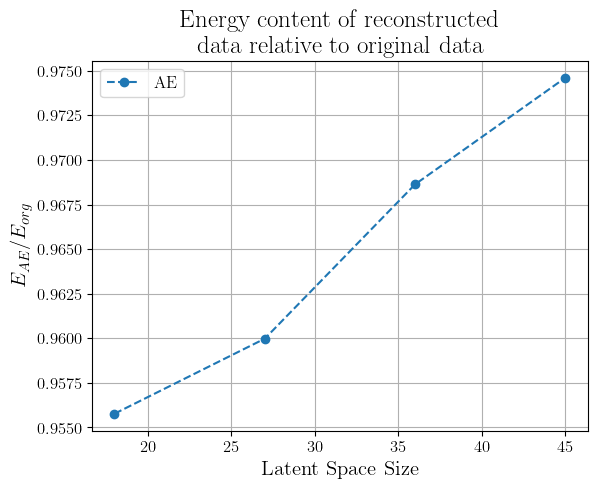

In [33]:
plt.plot(
    latent_states_size_list,
    np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og),
    '--',
    marker='o',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$E_{AE} / E_{org}$', fontsize=15)
plt.title('Energy content of reconstructed\ndata relative to original data', fontsize=18)
# plt.ylim([0, 1.2])

# xtick_labels = []
# for i in range(len(kernel_size_list)):
#     if len(kernel_size_list[i]) == 1:
#         xl = '$'+str(kernel_size_list[i][0])+'$'
#     else:
#         xl = '$[' + ', '.join([str(elem) for elem in np.sort(kernel_size_list[i])]) + ']$'
#     match_flag = False
#     for j in range(len(xtick_labels)):
#         if xtick_labels[j] == xl:
#             match_flag = True
#     if match_flag == False:
#         xtick_labels.append(xl)
        
# # plt.xticks(
# #     np.arange(0, len(kernel_size_list)),
# #     labels=[
# #         r'$'+', '.join([str(elem) for elem in kernels])+'$' for kernels in kernel_size_list
# #     ]
# # )
# plt.xticks(np.arange(0, len(xtick_labels)), labels=xtick_labels)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)


plt.savefig(save_dir+'/plots/energy_content_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

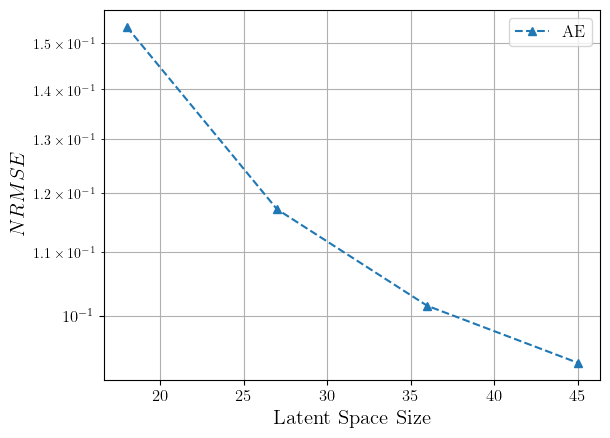

In [34]:
plt.semilogy(
    latent_states_size_list,
    AE_recon_NRMSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$NRMSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/NRMSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

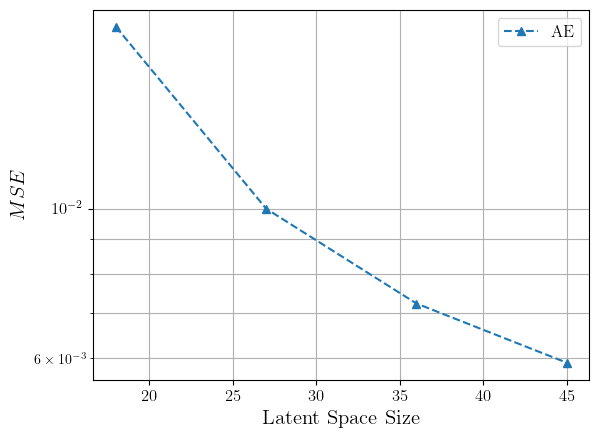

In [35]:
plt.semilogy(
    latent_states_size_list,
    AE_recon_MSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$MSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/MSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

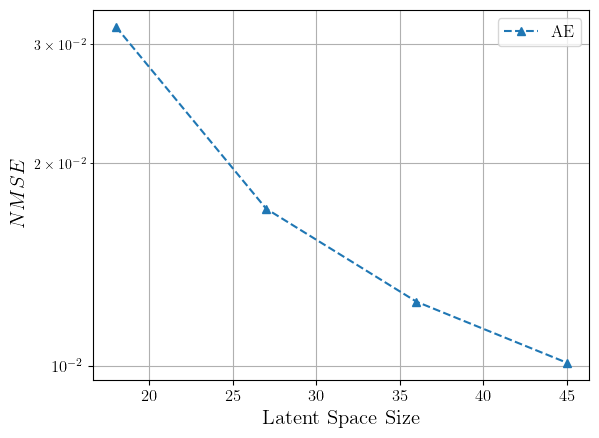

In [36]:
plt.semilogy(
    latent_states_size_list,
    AE_recon_NMSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$NMSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/NMSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

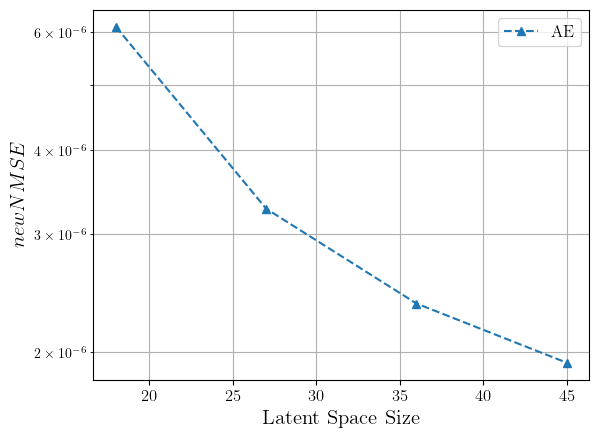

In [37]:
plt.semilogy(
    latent_states_size_list,
    AE_recon_newNMSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$newNMSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/newNMSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

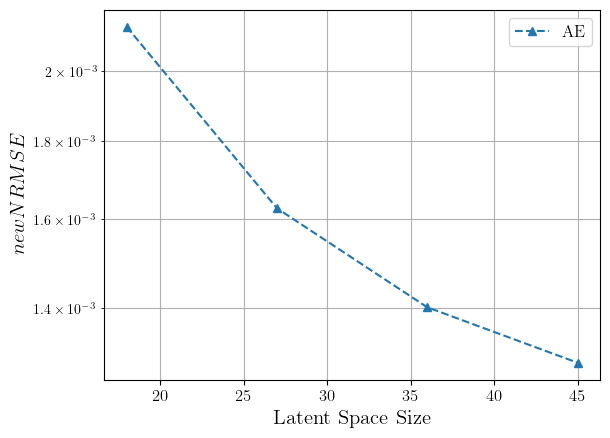

In [38]:
plt.semilogy(
    latent_states_size_list,
    AE_recon_newNRMSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$newNRMSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/newNRMSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

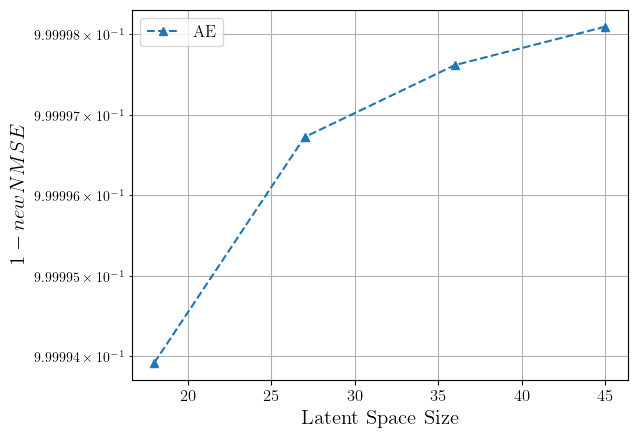

In [39]:
plt.semilogy(
    latent_states_size_list,
    1-AE_recon_newNMSE_lst,
    '--',
    marker='^',
    label=r'AE'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$1 - newNMSE$', fontsize=15)

plt.legend(fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/oneminus_newNMSE_ONLY_AE.pdf', dpi=300, bbox_inches='tight')
plt.show()

# POD

In [40]:
# for i in range(len(eigenvals)):
#     ev = eigenvals[i]
#     if ev < 0.0:
#         print(i, ev)
# #         eigenvals[i] *= -1
# #         eigenvecs[:, i] *= -1
# #         print(i, ev)

In [41]:
# sorted_idx = np.argsort(eigenvals)
# eigenvals = eigenvals[sorted_idx]
# eigenvecs = eigenvecs[:, sorted_idx]

In [42]:
# print(eigenvals)

# for i in range(eigenvecs.shape[1]):
#     print('norm(ev[:, {}]) : {}'.format(i, np.sum(eigenvecs[:, i]**2)))

In [43]:
latent_states_shape_set = set(latent_states_shape_list)
latent_states_shape_set = list(latent_states_shape_set)
print(latent_states_shape_set)

[(5, 3, 3), (2, 3, 3), (3, 3, 3), (4, 3, 3)]


In [44]:
# pod_timeAvgEnergySpectrum = []
# pod_idx_list = []
covmat_list_pod = {}
eigvals_list_pod = {}
POD_recon_MSE_lst = {}
POD_recon_RMSE_lst = {}
POD_recon_NMSE_lst = {}
POD_recon_NRMSE_lst = {}
POD_recon_newNRMSE_lst = {}
POD_recon_newNMSE_lst = {}

stddev_all_data = np.std(testing_data, axis=0)
stddev_all_data = np.reshape(stddev_all_data, (-1,))

for latent_states_shape in latent_states_shape_set:
    # num_latent_states = num_latent_states_list[i]
    num_latent_states = 1
    for dim in latent_states_shape:
        num_latent_states *= dim
    Wl = eigenvecs_trainingdata[:, -num_latent_states:]
    Xl = np.reshape(
        testing_data-podcentering_means_trainingdata,
        (testing_data.shape[0], -1)
    ) @ Wl @ Wl.transpose()
    Xl = np.reshape(Xl, (Xl.shape[0],)+tuple(all_data_og_shape[1:]))
    Xl += podcentering_means_trainingdata
    # FourierCoeffs = fft.fft(Xl, axis=1)
    # energySpectrum = FourierCoeffs.real**2 + FourierCoeffs.imag**2
    # energySpectrum = np.mean(energySpectrum, axis=0)
    # pod_timeAvgEnergySpectrum.append(energySpectrum)
    
    meancentereddata_pod = Xl - np.mean(Xl, axis=0)
    meancentereddata_flat_pod = np.reshape(meancentereddata_pod, (meancentereddata_pod.shape[0], -1))
    covmat_pod = np.matmul(meancentereddata_flat_pod.transpose(), meancentereddata_flat_pod) / (meancentereddata_pod.shape[0] - 1)
    eigvals_pod = np.abs(np.linalg.eigvals(covmat_pod))
    eigvals_pod = np.sort(eigvals_pod)
    eigvals_pod = eigvals_pod[::-1]
    covmat_list_pod[str(num_latent_states)] = covmat_pod
    eigvals_list_pod[str(num_latent_states)] = eigvals_pod
    
    reconstruction_MSE = (Xl - testing_data)**2
    reconstruction_MSE = np.reshape(reconstruction_MSE, (reconstruction_MSE.shape[0], -1))
#     stddev_all_data = np.std(all_data_og, axis=0)
    normalized_recon_MSE = np.average(reconstruction_MSE/stddev_all_data**2, axis=1)
    normalized_recon_RMSE = np.average(normalized_recon_MSE**0.5, axis=0)
    normalized_recon_MSE = np.average(normalized_recon_MSE, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=1)
    reconstruction_newNMSE = reconstruction_MSE / np.sum(stddev_all_data**2)
    reconstruction_newNRMSE = np.average(reconstruction_newNMSE**0.5, axis=0)
    reconstruction_newNMSE = np.average(reconstruction_newNMSE, axis=0)
    reconstruction_RMSE = np.average(reconstruction_MSE**0.5, axis=0)
    reconstruction_MSE = np.average(reconstruction_MSE, axis=0)
    
    POD_recon_MSE_lst[str(num_latent_states)] = reconstruction_MSE
    POD_recon_RMSE_lst[str(num_latent_states)] = reconstruction_RMSE
    POD_recon_NMSE_lst[str(num_latent_states)] = normalized_recon_MSE
    POD_recon_NRMSE_lst[str(num_latent_states)] = normalized_recon_RMSE
    POD_recon_newNRMSE_lst[str(num_latent_states)] = reconstruction_newNRMSE
    POD_recon_newNMSE_lst[str(num_latent_states)] = reconstruction_newNMSE

In [45]:
# POD_recon_MSE_lst = np.array(POD_recon_MSE_lst)
# POD_recon_RMSE_lst = np.array(POD_recon_RMSE_lst)
# POD_recon_NMSE_lst = np.array(POD_recon_NMSE_lst)
# POD_recon_NRMSE_lst = np.array(POD_recon_NRMSE_lst)
# POD_recon_newNRMSE_lst = np.array(POD_recon_newNRMSE_lst)

In [46]:
if type(POD_recon_MSE_lst) == type(np.array(['a'])):
    POD_recon_MSE_lst = POD_recon_MSE_lst.item()
if type(POD_recon_RMSE_lst) == type(np.array(['a'])):
    POD_recon_RMSE_lst = POD_recon_RMSE_lst.item()
if type(POD_recon_NMSE_lst) == type(np.array(['a'])):
    POD_recon_NMSE_lst = POD_recon_NMSE_lst.item()
if type(POD_recon_NRMSE_lst) == type(np.array(['a'])):
    POD_recon_NRMSE_lst = POD_recon_NRMSE_lst.item()
if type(POD_recon_newNRMSE_lst) == type(np.array(['a'])):
    POD_recon_newNRMSE_lst = POD_recon_newNRMSE_lst.item()
if type(POD_recon_newNMSE_lst) == type(np.array(['a'])):
    POD_recon_newNMSE_lst = POD_recon_newNMSE_lst.item()

In [47]:
print('num_latent_states : ', num_latent_states)

num_latent_states :  36


# Comparison of Time Averaged RMSE

In [48]:
eigvals_list_pod_plot = []
for i in range(len(latent_states_size_list)):
    eigvals_list_pod_plot.append(eigvals_list_pod[str(latent_states_size_list[i])])

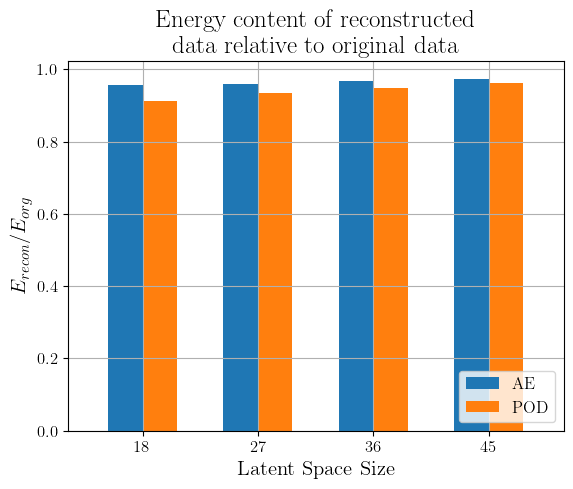

In [49]:
width = 0.3
ind = np.arange(len(latent_states_size_list), dtype=FTYPE)# - 0.5*width


plt.bar(
    ind-0.5*width,
    np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og),
    width,
    label=r'AE'
)


plt.bar(
    ind+0.5*width,
    np.sum(eigvals_list_pod_plot, axis=1)/np.sum(eigvals_og),
    width,
    label=r'POD'
)

# plt.bar(ind+width, np.sum(eigvals_list_pod, axis=1)/np.sum(eigvals_og), width, label='POD')


plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('$E_{recon} / E_{org}$', fontsize=15)
plt.title('Energy content of reconstructed\ndata relative to original data', fontsize=18)
plt.xticks(ind, [r''+str(elem) for elem in latent_states_size_list])

# plt.ylim([-0.05, 1.05])
plt.xlim(ind[0]-0.5*width-0.5, ind[-1]+0.5*width+0.5)
plt.legend(loc='lower right', fontsize=12)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)

plt.savefig(save_dir+'/plots/energy_content_AE_and_POD.pdf', dpi=300, bbox_inches='tight')
plt.show()

# print('AE:', np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
# print('POD:', np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
# print('AE:', np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og))
# print('POD:', np.sum(eigvals_list_pod, axis=1)/np.sum(eigvals_og))

with open(save_dir+'/energy_content_AE_POD.txt', 'w') as f:
    s =  '   kernel_size_list : '
    temp_lst = [str(elem) for elem in kernel_size_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += 'attention_used_list : '
    temp_lst = [str(elem) for elem in attention_used_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '  latent_space_size : '
    temp_lst = [str(elem) for elem in latent_states_size_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '                 AE : '
    temp_lst = ["{:.4f} %".format(100*elem) for elem in np.sum(eigvals_list_AE, axis=1)/np.sum(eigvals_og)]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '                POD : '
    temp_lst = ["{:.4f} %".format(100*elem) for elem in np.sum(eigvals_list_pod_plot, axis=1)/np.sum(eigvals_og)]
    s += ', '.join(temp_lst)
    s += "\n"
    f.write(s)

In [50]:
error_type_list = [
    'MSE',
    'RMSE',
    'NMSE',
    'NRMSE',
    'newNMSE',
    'newNRMSE',
]

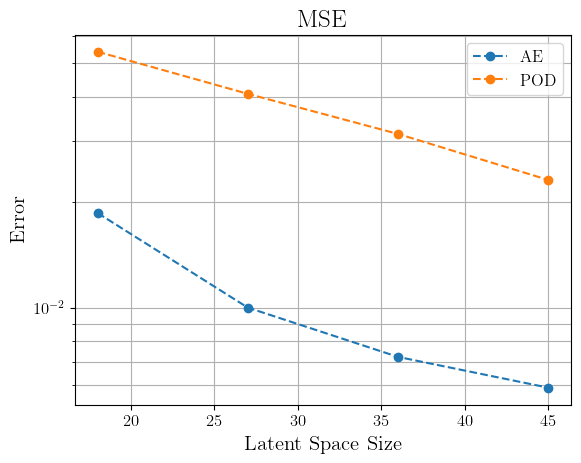

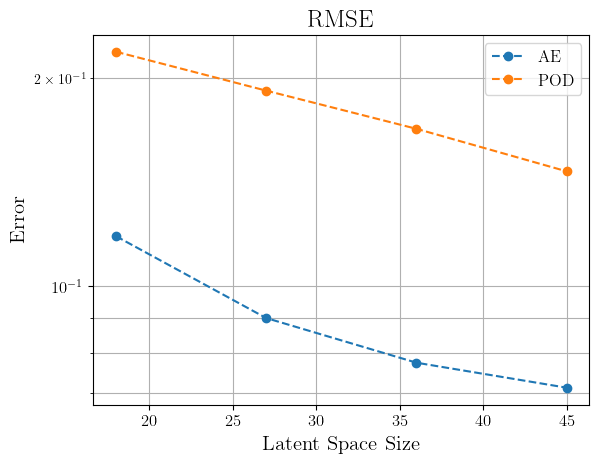

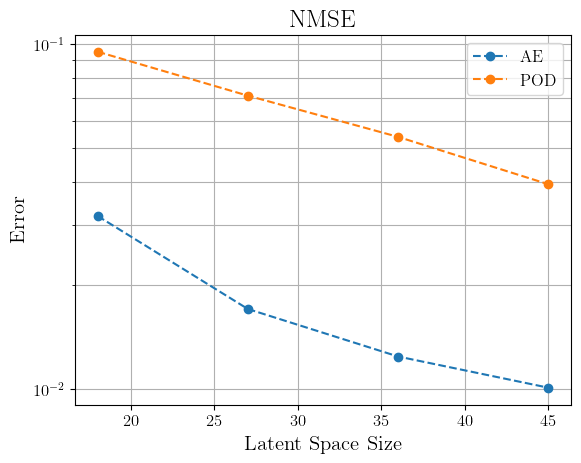

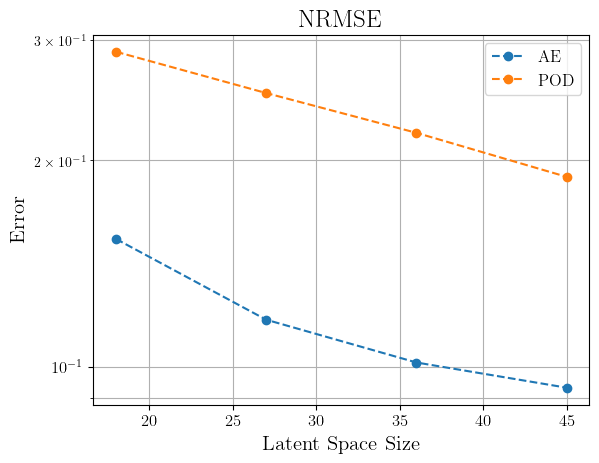

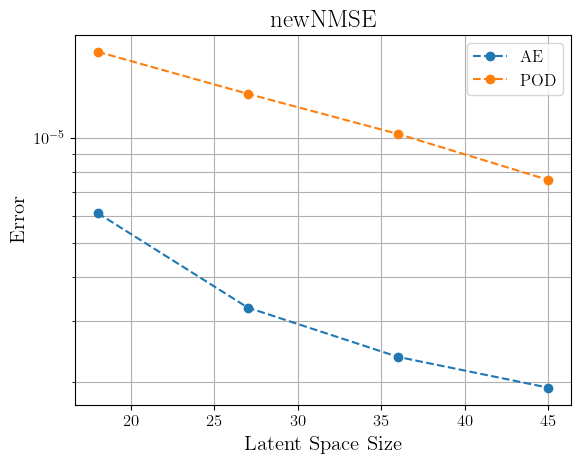

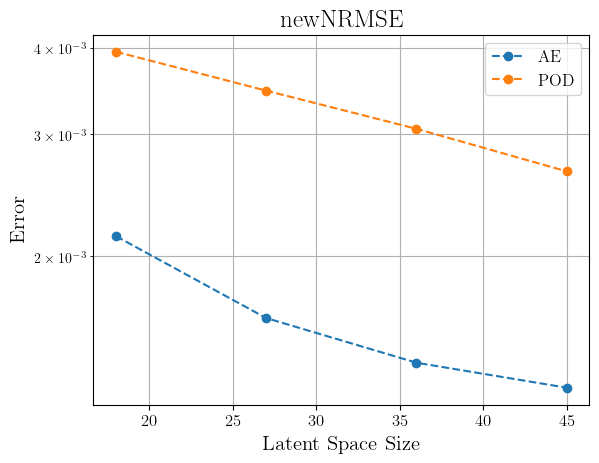

<Figure size 640x480 with 0 Axes>

In [51]:
# reconstruction errors
for error_type in error_type_list:
    AE_error = eval('AE_recon_'+error_type+'_lst')
    POD_error = eval('POD_recon_'+error_type+'_lst')

    if len(np.where(attention_used_list==True)[0]) > 0:
        plt.semilogy(
            latent_states_size_list,
            AE_error,
            '--',
            marker='o',
            label=r'AE'
        )

    plt.semilogy(
        latent_states_size_list,
        [POD_error[str(elem)] for elem in latent_states_size_list],
        '--',
        marker='o',
        label=r'POD'
    )
    plt.grid(True, which='both', axis='y')
    plt.grid(True, which='major', axis='x')
    plt.xlabel('Latent Space Size', fontsize=15)
    plt.ylabel('Error', fontsize=15)
    plt.title(error_type, fontsize=18)

    # plt.ylim([-0.05, 1.05])
    # plt.xlim(-0.5, ind[-1]+width+0.5)
    plt.gca().tick_params(axis='x', labelsize=12)
    plt.gca().tick_params(axis='y', labelsize=12)
    plt.legend(fontsize=12)#loc='lower right')

    # plt.savefig('AE_POD_'+error_type+'.png', dpi=300, bbox_inches='tight')
    plt.savefig(save_dir+'/plots/AE_POD_'+error_type+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()


    with open(save_dir+'/AE_POD_'+error_type+'.txt', 'w') as f:
        s =  '   kernel_size_list : '
        temp_lst = [str(elem) for elem in kernel_size_list]
        s += ', '.join(temp_lst)
        s += "\n"
        s += 'attention_used_list : '
        temp_lst = [str(elem) for elem in attention_used_list]
        s += ', '.join(temp_lst)
        s += "\n"
        s += '  latent_space_size : '
        temp_lst = [str(elem) for elem in latent_states_size_list]
        s += ', '.join(temp_lst)
        s += "\n"
        s += '                 AE : '
        temp_lst = ["{:.4E}".format(elem) for elem in AE_error]
        s += ', '.join(temp_lst)
        s += "\n"
        s += '                POD : '
        temp_lst = ["{:.4E}".format(elem) for elem in [POD_error[str(elem)] for elem in latent_states_size_list]]
        s += ', '.join(temp_lst)
        s += "\n"
        f.write(s)
        
    plt.clf()

In [57]:
AE_recon_newNMSE_lst

array([6.1014835e-06, 3.2706769e-06, 2.3636369e-06, 1.9297972e-06],
      dtype=float32)

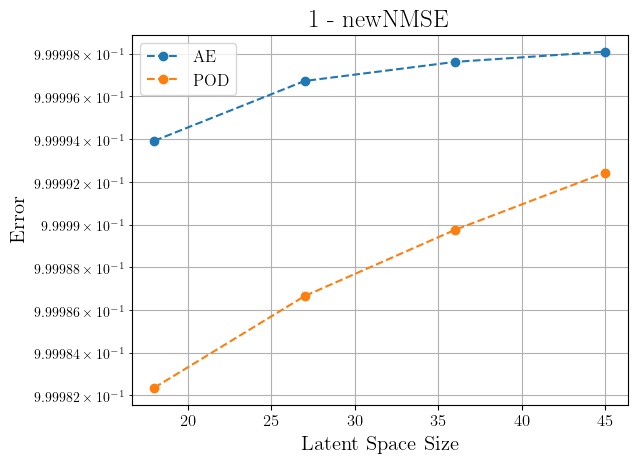

<Figure size 640x480 with 0 Axes>

In [60]:
# reconstruction errors
error_type = 'newNMSE'
AE_error = eval('AE_recon_'+error_type+'_lst')
POD_error = eval('POD_recon_'+error_type+'_lst')

AE_error = 1-np.array([elem for elem in AE_error])
POD_error = 1 - np.array([POD_error[str(elem)] for elem in latent_states_size_list])

if len(np.where(attention_used_list==True)[0]) > 0:
    plt.semilogy(
        latent_states_size_list,
        np.array(AE_error),
        '--',
        marker='o',
        label=r'AE'
    )

plt.semilogy(
    latent_states_size_list,
    POD_error,
    '--',
    marker='o',
    label=r'POD'
)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='major', axis='x')
plt.xlabel('Latent Space Size', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('1 - newNMSE', fontsize=18)

# plt.ylim([-0.05, 1.05])
# plt.xlim(-0.5, ind[-1]+width+0.5)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12)#loc='lower right')

# plt.savefig('AE_POD_'+error_type+'.png', dpi=300, bbox_inches='tight')
plt.savefig(save_dir+'/plots/AE_POD_oneminus_newNMSE.pdf', dpi=300, bbox_inches='tight')
plt.show()


with open(save_dir+'/AE_POD_oneminuse_newNMSE.txt', 'w') as f:
    s =  '   kernel_size_list : '
    temp_lst = [str(elem) for elem in kernel_size_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += 'attention_used_list : '
    temp_lst = [str(elem) for elem in attention_used_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '  latent_space_size : '
    temp_lst = [str(elem) for elem in latent_states_size_list]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '                 AE : '
    temp_lst = ["{:.8E}".format(elem) for elem in AE_error]
    s += ', '.join(temp_lst)
    s += "\n"
    s += '                POD : '
    temp_lst = ["{:.8E}".format(elem) for elem in POD_error]
    s += ', '.join(temp_lst)
    s += "\n"
    f.write(s)

plt.clf()

In [ ]:
k = fft.fftfreq(og_vars, d=1/og_vars)
idx = np.where(k<0)[0]
k[idx] += og_vars
print(k)#*numpoints_xgrid*2*np.pi/xgrid[-1])

In [ ]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
for i in range(len(chosen_dir_list)):
    y2 = timeAvgEnergySpectrum[i]/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
    y3 = pod_timeAvgEnergySpectrum[i]/np.sum(energySpectrum_og)# np.sum(pod_timeAvgEnergySpectrum[i])
    plt.semilogy(k, y3, marker='s', markersize=3, linewidth=0.95, linestyle='--', label='POD Reconstruction')
    plt.semilogy(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
    plt.semilogy(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='AE Reconstruction')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]))
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
for i in range(len(chosen_dir_list)):
    fig_eigvals, ax_eigvals = plt.subplots()
    ax_eigvals.semilogy(eigvals_og, linestyle='--', marker='s', linewidth=0.9, markersize=2)
    ax_eigvals.semilogy(eigvals_list_pod[i], linestyle='--', marker='^', linewidth=0.9, markersize=2)
    ax_eigvals.semilogy(eigvals_list_AE[i], linestyle='--', marker='^', linewidth=0.9, markersize=2)
    ax_eigvals.grid(True)
    ax_eigvals.legend([r'Original Data', r'POD Reconstruction', r'AE Reconstruction'])
    ax_eigvals.set_axisbelow(True)
    ax_eigvals.set_title('Eigenvalues of the covariance matrix')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]))
    plt.show()

In [ ]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()
for i in range(len(chosen_dir_list)):
    fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
    subplot1 = 1
    subplot2 = subplot1 + 1
    
    covmat_ae_normd = np.divide(np.transpose(covmat_list_AE[i]), np.diag(covmat_og)).transpose()

    vmin_snap = 0.05
    vmax_snap = 0.05
    vmin = np.min([
        covmat_og_normd.min(),
        covmat_ae_normd.min()
    ])
    vmin = min(vmin, -1.0)
    vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
    vmax = np.max([
        covmat_og_normd.max(),
        covmat_ae_normd.max()
    ])
    vmax = max(vmax, 1.0)
    vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

    # plotting the original data
    ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
    im_orig = ax_covmat_orig.imshow(
        covmat_og_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_orig.title.set_text('Covariance Matrix (True Data)')
    # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
    # ax_covmat_orig.set_xticks(ticks=xticks)
    # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
    # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
    # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
    # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
    # ax_covmat_orig.set_yticks(ticks=yticks)
    # ax_covmat_orig.set_yticklabels(yticklabels)
    # ax_covmat_orig.set_xlabel(xlabel)
    # ax_covmat_orig.set_ylabel(ylabel)

    # plotting the predicted data
    ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_predict = ax_covmat_predict.imshow(
        covmat_ae_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_predict.title.set_text('Covariance Matrix (AE Data)')
    # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
    # ax_covmat_predict.set_xlabel(xlabel)
    # ax_covmat_predict.set_ylabel(ylabel)

    # subplots adjustment to account for colorbars
    fig_covmat.subplots_adjust(
        bottom=0.2,
        left=0.1,
    )

    # original data and recon data colorbar
    cb_xbegin = ax_covmat_orig.transData.transform([0, 0])
    cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
    cb_xend = ax_covmat_predict.transData.transform([covmat_ae_normd.shape[-1], 0])
    cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

    cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
    cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

    # computing the normalized error
    subplot3 = subplot2+1
    error = np.abs(covmat_og_normd-covmat_ae_normd)
    vmax_error_snap = 0.02
    vmax_error = np.max(error)
    vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
    # error = 100*error / np.abs(pod_covmat_dataout)
    # plotting the normalized error
    ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_error = ax_covmat_error.imshow(
        error,
        aspect='equal',
        origin='upper',
        vmin=0.0,
        vmax=vmax_error
    )
    ax_covmat_error.title.set_text(r'Error')
    # ax_error.tick_params(axis='x', rotation=270+45)
    # ax_error.set_xlabel(xlabel)
    # ax_error.set_ylabel(ylabel)

    # error colorbar
    cbe_xbegin = ax_covmat_error.transData.transform([0, 0])
    cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
    cbe_xend = ax_covmat_error.transData.transform([covmat_ae_normd.shape[-1], 0])
    cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
    error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
    error_cb_ax.tick_params(axis='x', rotation=270+45)
    cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]))
    plt.show()

In [ ]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()
for i in range(len(chosen_dir_list)):
    fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
    subplot1 = 1
    subplot2 = subplot1 + 1
    
    covmat_pod_normd = np.divide(np.transpose(covmat_list_pod[i]), np.diag(covmat_og)).transpose()

    vmin_snap = 0.05
    vmax_snap = 0.05
    vmin = np.min([
        covmat_og_normd.min(),
        covmat_pod_normd.min()
    ])
    vmin = min(vmin, -1.0)
    vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
    vmax = np.max([
        covmat_og_normd.max(),
        covmat_pod_normd.max()
    ])
    vmax = max(vmax, 1.0)
    vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

    # plotting the original data
    ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
    im_orig = ax_covmat_orig.imshow(
        covmat_og_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_orig.title.set_text('Covariance Matrix (True Data)')
    # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
    # ax_covmat_orig.set_xticks(ticks=xticks)
    # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
    # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
    # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
    # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
    # ax_covmat_orig.set_yticks(ticks=yticks)
    # ax_covmat_orig.set_yticklabels(yticklabels)
    # ax_covmat_orig.set_xlabel(xlabel)
    # ax_covmat_orig.set_ylabel(ylabel)

    # plotting the predicted data
    ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_predict = ax_covmat_predict.imshow(
        covmat_pod_normd,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_predict.title.set_text('Covariance Matrix (POD Data)')
    # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
    # ax_covmat_predict.set_xlabel(xlabel)
    # ax_covmat_predict.set_ylabel(ylabel)

    # subplots adjustment to account for colorbars
    fig_covmat.subplots_adjust(
        bottom=0.2,
        left=0.1,
    )

    # original data and recon data colorbar
    cb_xbegin = ax_covmat_orig.transData.transform([0, 0])
    cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
    cb_xend = ax_covmat_predict.transData.transform([covmat_pod_normd.shape[-1], 0])
    cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

    cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
    cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

    # computing the normalized error
    subplot3 = subplot2+1
    error = np.abs(covmat_og_normd-covmat_pod_normd)
    vmax_error_snap = 0.01
    vmax_error = np.max(error)
    vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
    # error = 100*error / np.abs(pod_covmat_dataout)
    # plotting the normalized error
    ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_error = ax_covmat_error.imshow(
        error,
        aspect='equal',
        origin='upper',
        vmin=0.0,
        vmax=vmax_error
    )
    ax_covmat_error.title.set_text(r'Error')
    # ax_error.tick_params(axis='x', rotation=270+45)
    # ax_error.set_xlabel(xlabel)
    # ax_error.set_ylabel(ylabel)

    # error colorbar
    cbe_xbegin = ax_covmat_error.transData.transform([0, 0])
    cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
    cbe_xend = ax_covmat_error.transData.transform([covmat_pod_normd.shape[-1], 0])
    cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
    error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
    error_cb_ax.tick_params(axis='x', rotation=270+45)
    cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]))
    plt.show()